In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,Dropout,Activation,BatchNormalization
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import warnings 
warnings.filterwarnings('ignore')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [2]:
train_data = pd.read_csv('../input/ahcd1/Arabic Handwritten Characters Dataset CSV/csvTrainImages 13440x1024.csv', header = None).values
train_label = pd.read_csv('../input/ahcd1/Arabic Handwritten Characters Dataset CSV/csvTrainLabel 13440x1.csv', header = None)
test_data = pd.read_csv('../input/ahcd1/Arabic Handwritten Characters Dataset CSV/csvTestImages 3360x1024.csv', header = None).values
test_label = pd.read_csv('../input/ahcd1/Arabic Handwritten Characters Dataset CSV/csvTestLabel 3360x1.csv', header = None)

In [3]:
train_label = train_label.squeeze()
test_label = test_label.squeeze()

In [4]:
characters = ["ا","ب","ت","ث","ج","ح","خ","د","ذ","ر","ز","س","ش","ص","ض","ط","ظ","ع","غ","ف","ق","ك","ل","م","ن","ه","و","ي"]
characters_dict = dict(zip(np.arange(1,len(characters)+1), characters))

In [5]:
train_label = train_label.map(characters_dict).values
test_label = test_label.map(characters_dict).values

In [6]:
x_train = (train_data).reshape(-1,32,32,1)
x_test = (test_data).reshape(-1,32,32,1)

In [7]:
x_train,train_label = shuffle(x_train,train_label)
x_test,test_label = shuffle(x_test,test_label)

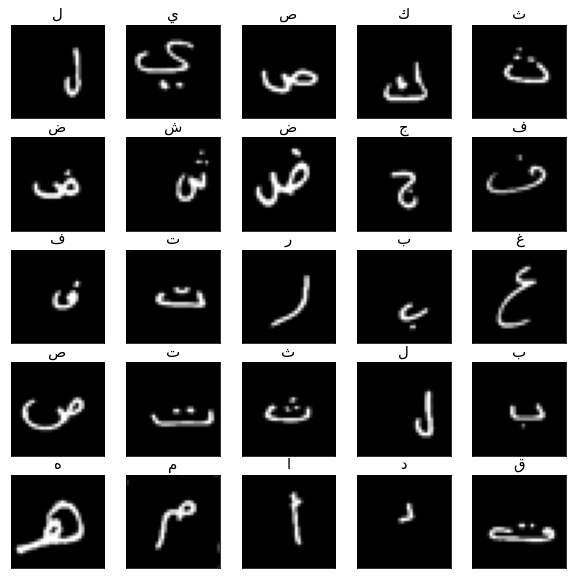

In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i].reshape(32,32).T,"gray")
    plt.title(train_label[i][0],fontsize = 15)
plt.show()


In [9]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
train_label = lb.fit_transform(train_label)
test_label = lb.fit_transform(test_label)

In [10]:
train_datagen=ImageDataGenerator(
    zoom_range=0.2, #the amount of zooming u need
    horizontal_flip=True, # Make a horizontal copy of image
    rescale=1/255, # Normalize the new images
    width_shift_range=0.10, # The percentage of Width shifitning
    height_shift_range=0.10, # The percentage of height shifitning
    shear_range=0.1, #Shear angle in counter-clockwise direction in degrees
    fill_mode='nearest',
    rotation_range=20, 
)
train_generator=train_datagen.flow(
    x_train ,train_label ,batch_size=64
)

test_datagen=ImageDataGenerator(rescale=1/255)
test_generator=test_datagen.flow(
    x_test ,test_label ,batch_size=64
 
)

In [11]:
earlystop=EarlyStopping(patience=6)
learning_rate_reduction=ReduceLROnPlateau(
    monitor='val_acc',
    patience= 3,
    verbose=1,
)
callbacks = [earlystop, learning_rate_reduction]

In [12]:
model=Sequential() 

model.add(Conv2D(32,(5,5), padding="same",activation='relu',input_shape=(32,32,1)))
model.add(Conv2D(32,(5,5), padding="same",activation='relu'))
model.add(Conv2D(32,(5,5),activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(28,activation='softmax'))

In [13]:
model.compile(optimizer='adam' ,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        25632     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               802944    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1

In [15]:
model.fit(
    train_generator, 
    epochs=50,
    validation_data=test_generator,
    callbacks=callbacks
)

Epoch 1/50
210/210 [==============================] - 12s 25ms/step - loss: 2.8919 - accuracy: 0.1319 - val_loss: 1.7564 - val_accuracy: 0.4286
Epoch 2/50
210/210 [==============================] - 5s 26ms/step - loss: 1.9626 - accuracy: 0.3339 - val_loss: 1.0601 - val_accuracy: 0.6193
Epoch 3/50
210/210 [==============================] - 5s 26ms/step - loss: 1.5086 - accuracy: 0.4696 - val_loss: 0.7938 - val_accuracy: 0.7182
Epoch 4/50
210/210 [==============================] - 5s 24ms/step - loss: 1.2460 - accuracy: 0.5603 - val_loss: 0.6628 - val_accuracy: 0.7824
Epoch 5/50
210/210 [==============================] - 5s 25ms/step - loss: 1.0768 - accuracy: 0.6276 - val_loss: 0.5374 - val_accuracy: 0.8199
Epoch 6/50
210/210 [==============================] - 5s 23ms/step - loss: 0.9378 - accuracy: 0.6823 - val_loss: 0.4560 - val_accuracy: 0.8372
Epoch 7/50
210/210 [==============================] - 5s 23ms/step - loss: 0.8402 - accuracy: 0.7133 - val_loss: 0.4278 - val_accuracy: 0.850

<AxesSubplot:>

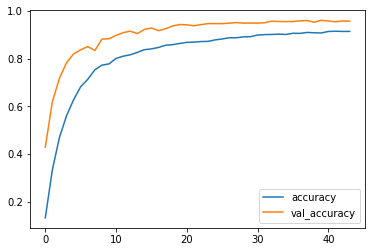

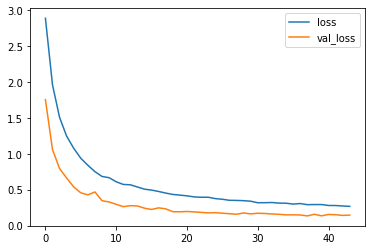

In [16]:
losses = pd.DataFrame(model.history.history)
losses[['accuracy','val_accuracy']].plot()
losses[['loss','val_loss']].plot()

In [17]:
model.evaluate(test_generator)

53/53 [==============================] - 0s 4ms/step - loss: 0.1451 - accuracy: 0.9571


[0.14514751732349396, 0.9571428298950195]